In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io

In [2]:
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\SBJ01\S01\Test\runs_per_block.txt
data\SBJ01\S01\Test\testData.mat
data\SBJ01\S01\Test\testEvents.txt
data\SBJ01\S01\Test\testLabels.txt
data\SBJ01\S01\Test\testTargets.txt
data\SBJ01\S01\Train\trainData.mat
data\SBJ01\S01\Train\trainEvents.txt
data\SBJ01\S01\Train\trainLabels.txt
data\SBJ01\S01\Train\trainTargets.txt
data\SBJ01\S02\Test\runs_per_block.txt
data\SBJ01\S02\Test\testData.mat
data\SBJ01\S02\Test\testEvents.txt
data\SBJ01\S02\Test\testLabels.txt
data\SBJ01\S02\Test\testTargets.txt
data\SBJ01\S02\Train\trainData.mat
data\SBJ01\S02\Train\trainEvents.txt
data\SBJ01\S02\Train\trainLabels.txt
data\SBJ01\S02\Train\trainTargets.txt
data\SBJ01\S03\Test\runs_per_block.txt
data\SBJ01\S03\Test\testData.mat
data\SBJ01\S03\Test\testEvents.txt
data\SBJ01\S03\Test\testLabels.txt
data\SBJ01\S03\Test\testTargets.txt
data\SBJ01\S03\Train\trainData.mat
data\SBJ01\S03\Train\trainEvents.txt
data\SBJ01\S03\Train\trainLabels.txt
data\SBJ01\S03\Train\trainTargets.txt
data\SBJ01\S04\Test\runs_

In [3]:
mats8s1 = scipy.io.loadmat('data/SBJ08/S01/Train/trainData.mat')
mats8s1.items()
mat2s8s1 = scipy.io.loadmat('data/SBJ08/S01/Test/testData.mat')
mat2s8s1.items()
X_trains8s1 = mats8s1["trainData"].transpose((2, 1, 0))
X_tests8s1 = mat2s8s1["testData"].transpose((2, 1, 0))
Y_trains8s1 = np.loadtxt("data/SBJ08/S01/Train/trainTargets.txt", dtype=int)
Y_tests8s1 = np.loadtxt("data/SBJ08/S01/Test/testTargets.txt", dtype=int)
##print(File_data)
##X_train.shape
#Y_train = Y_train[0:1600]
print(X_trains8s1.shape)
print(Y_trains8s1.shape)
print(X_tests8s1.shape)
print(Y_tests8s1.shape)

(1600, 350, 8)
(1600,)
(3200, 350, 8)
(3200,)


In [4]:
X_data=X_tests8s1
Y_data=Y_tests8s1

In [5]:
X_data.shape

(3200, 350, 8)

In [6]:
Y_data.shape

(3200,)

In [22]:
!pip install antropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 9.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [antropy]m1/3 [numba]


In [24]:
!pip install mne

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.0 MB/s eta 0:00:00a 0:00:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [mne]4/5 [mne]


In [26]:
!pip install nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nolds]


In [7]:
import numpy as np
from scipy.signal import wiener
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mne.decoding import CSP
from antropy import spectral_entropy, higuchi_fd

# Step 1: Fast Vectorized Wiener Filtering
def wiener_filter_eeg(X):
    # X shape: (samples, time, channels)
    X_filtered = np.empty_like(X)
    for ch in range(X.shape[2]):
        X_filtered[:, :, ch] = np.array([wiener(trial[:, ch]) for trial in X])
    return X_filtered

# Step 2a: CSP Feature Extraction (Supervised)
def extract_csp_features(X, y, n_components=4):
    X = X.astype(np.float64)  # Ensure CSP input is float64
    csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
    return csp.fit_transform(X, y)

# Step 2b: Fast Spectral Entropy Features (Unsupervised)
def extract_entropy_features(X):
    # shape: (samples, channels)
    return np.array([
        [spectral_entropy(trial[:, ch], sf=100, method='fft') for ch in range(trial.shape[1])]
        for trial in X
    ])

# Step 2c: Fast Higuchi Fractal Dimension (as proxy for corr. dim)
from antropy import higuchi_fd

def extract_fractal_features(X, kmax=10):
    return np.array([
        [higuchi_fd(np.array(trial[:, ch].copy()), kmax=kmax) for ch in range(trial.shape[1])]
        for trial in X
    ])

# Full Preprocessing Pipeline
def extract_all_features(X_raw, Y_data, csp_components=4):
    print("🧼 Applying Wiener filter...")
    X_wiener = wiener_filter_eeg(X_raw)

    print("🧠 Extracting CSP features...")
    X_csp = extract_csp_features(X_wiener, Y_data, n_components=csp_components)

    print("📊 Extracting Spectral Entropy features...")
    X_entropy = extract_entropy_features(X_wiener)
    X_entropy_mean = np.mean(X_entropy, axis=1, keepdims=True)  # (samples, 1)

    print("📈 Extracting Fractal Dimension features...")
    X_fractal = extract_fractal_features(X_wiener)
    X_fractal_mean = np.mean(X_fractal, axis=1, keepdims=True)  # (samples, 1)

    print("🔗 Combining all features...")
    X_combined = np.concatenate([X_csp, X_entropy_mean, X_fractal_mean], axis=1)
    print(f"✅ Feature extraction complete. Final shape: {X_combined.shape}")

    return X_combined


In [8]:
# Assume X_data: shape (3200, 350, 8) — trials, timesteps, channels
#       Y_data: shape (3200, )

features = extract_all_features(X_data, Y_data)


🧼 Applying Wiener filter...
🧠 Extracting CSP features...
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 350 dim * 2.2e+16  max singular value)
    Estimated rank (data): 350
    data: rank 350 computed from 350 data channels with 0 projectors
Reducing data rank from 350 -> 350
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
📊 Extracting Spectral Entropy features...
📈 Extracting Fractal Dimension features...
🔗 Combining all features...
✅ Feature extraction complete. Final shape: (3200, 6)


In [9]:
print(features[9])

[-1.91173323 -2.56006244 -1.90939227 -2.38454123  2.66912699  1.42584779]


In [10]:
# Get unique classes and their counts
unique_classes, counts = np.unique(Y_data, return_counts=True)

# Print class distribution
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

Class 0: 2800 samples
Class 1: 400 samples


In [11]:
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=0)
x_resampled, y_resampled=ros.fit_resample(features, Y_data)

In [12]:
# Get unique classes and their counts
unique_classes, counts = np.unique(y_resampled, return_counts=True)

# Print class distribution
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

Class 0: 2800 samples
Class 1: 2800 samples


In [13]:
X=x_resampled
Y=y_resampled

In [14]:
import numpy as np

def one_hot_encode_autism(y):
    """
    Encode labels such that:
    - Class 0 (Not Autism) → [1, 0]
    - Class 1 (Autism)     → [0, 1]
    """
    y = np.array(y).astype(int)
    one_hot = np.zeros((y.shape[0], 2))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# Example usage:
Y_onehot = one_hot_encode_autism(Y)

# Confirm:
print("One-hot encoded labels (first 5):\n", Y_onehot[:5])


One-hot encoded labels (first 5):
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [15]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
# ⚠️ Use raw labels for stratify (not one-hot)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y_onehot,
    test_size=0.2,
    random_state=42,
    stratify=Y  # Use original labels (not one-hot) for stratification
)


In [16]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4480, 6)
X_test shape: (1120, 6)
y_train shape: (4480, 2)
y_test shape: (1120, 2)


In [17]:
y_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_bilstm_transformer(input_shape=(6,), num_classes=2):
    inputs = layers.Input(shape=input_shape)  # (6,)
    
    # Reshape input for sequence modeling: (timesteps=6, features=1)
    x = layers.Reshape((input_shape[0], 1))(inputs)  # (6, 1)

    # === 1D CNN BLOCK ===
    x = layers.Conv1D(64, kernel_size=2, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=2, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # === BIDIRECTIONAL LSTM BLOCK ===
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)  # (6, 128)

    # === TRANSFORMER ENCODER BLOCK ===
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # (6, 128)
    attention_output = layers.LayerNormalization()(attention_output + x)  # residual + norm

    ff = layers.Dense(128, activation='relu')(attention_output)
    ff = layers.Dense(64)(ff)

    # Project attention output to match ff's shape before addition
    attention_proj = layers.Dense(64)(attention_output)  # now shape (6, 64)

    x = layers.LayerNormalization()(ff + attention_proj)  # (6, 64)

    # === OUTPUT BLOCK ===
    x = layers.GlobalAveragePooling1D()(x)  # (64,)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # === COMPILE MODEL ===
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [19]:
model = build_cnn_bilstm_transformer(input_shape=(6,), num_classes=2)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 reshape (Reshape)           (None, 6, 1)                 0         ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 6, 64)                192       ['reshape[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 6, 64)                256       ['conv1d[0][0]']              
 Normalization)                                                                             

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss')
]


In [21]:
history = model.fit(
    X_train, y_train,
     validation_split=0.2,
    epochs=200,
    batch_size=32,
   
    verbose=1
)

Epoch 1/200


112/112 [==============================] - 8s 22ms/step - loss: 0.5509 - accuracy: 0.7274 - val_loss: 0.7725 - val_accuracy: 0.5982
Epoch 2/200
112/112 [==============================] - 1s 13ms/step - loss: 0.4980 - accuracy: 0.7612 - val_loss: 0.5309 - val_accuracy: 0.7411
Epoch 3/200
112/112 [==============================] - 1s 13ms/step - loss: 0.4867 - accuracy: 0.7628 - val_loss: 0.5638 - val_accuracy: 0.6987
Epoch 4/200
112/112 [==============================] - 1s 13ms/step - loss: 0.4826 - accuracy: 0.7704 - val_loss: 0.5308 - val_accuracy: 0.7388
Epoch 5/200
112/112 [==============================] - 1s 13ms/step - loss: 0.4730 - accuracy: 0.7681 - val_loss: 0.4998 - val_accuracy: 0.7500
Epoch 6/200
112/112 [==============================] - 1s 13ms/step - loss: 0.4722 - accuracy: 0.7768 - val_loss: 0.5123 - val_accuracy: 0.7411
Epoch 7/200
112/112 [==============================] - 1s 13ms/step - loss: 0.4795 - accuracy: 0.7706 - val_loss: 0.5107 - val_accurac

200/200 [==============================] - 2s 9ms/step


ExactExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

22/22 [==============================] - 0s 10ms/step


ExactExplainer explainer:  30%|███       | 3/10 [00:13<00:08,  1.24s/it]

22/22 [==============================] - 0s 9ms/step


ExactExplainer explainer:  40%|████      | 4/10 [00:16<00:10,  1.78s/it]

22/22 [==============================] - 0s 10ms/step


ExactExplainer explainer:  50%|█████     | 5/10 [00:18<00:10,  2.04s/it]

22/22 [==============================] - 0s 9ms/step


ExactExplainer explainer:  60%|██████    | 6/10 [00:21<00:08,  2.16s/it]

22/22 [==============================] - 0s 10ms/step


ExactExplainer explainer:  70%|███████   | 7/10 [00:23<00:06,  2.25s/it]

22/22 [==============================] - 0s 11ms/step


ExactExplainer explainer:  80%|████████  | 8/10 [00:26<00:04,  2.32s/it]

22/22 [==============================] - 0s 9ms/step


ExactExplainer explainer:  90%|█████████ | 9/10 [00:28<00:02,  2.36s/it]

22/22 [==============================] - 0s 10ms/step


ExactExplainer explainer: 100%|██████████| 10/10 [00:30<00:00,  2.38s/it]

22/22 [==============================] - 0s 10ms/step


ExactExplainer explainer: 11it [00:33,  3.34s/it]                        

Class 0: Non-Autistic



C:\Users\KIIT\AppData\Local\Temp\ipykernel_21336\2959617553.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_class0.values, X_sample, feature_names=[f'Feature {i+1}' for i in range(X_sample.shape[1])])


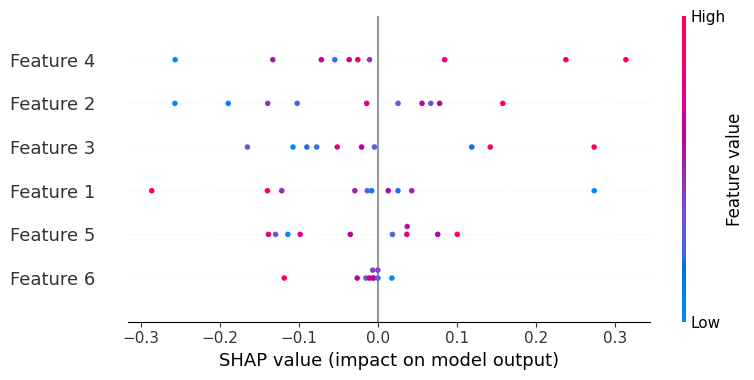

Class 1: Autistic


C:\Users\KIIT\AppData\Local\Temp\ipykernel_21336\2959617553.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_class1.values, X_sample, feature_names=[f'Feature {i+1}' for i in range(X_sample.shape[1])])


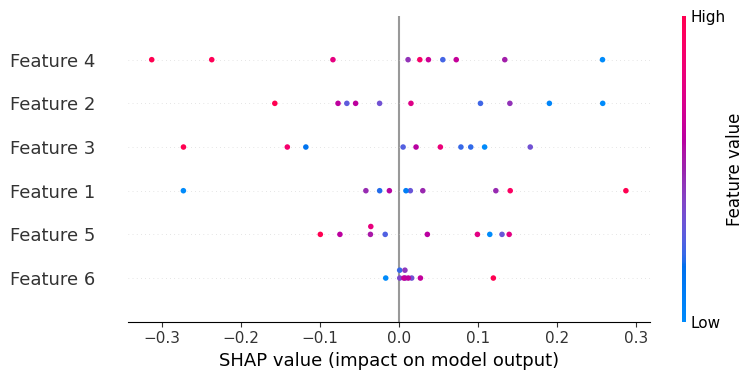

In [30]:
import shap
import numpy as np

# Background data for SHAP
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
X_sample = X_train[:10]

# SHAP modern Explainer API
explainer = shap.Explainer(model.predict, background)

# Compute SHAP values
shap_values = explainer(X_sample)  # shap_values.shape = (10, 6, 2) --> samples × features × classes

# Extract for class 0 (Non-Autistic) and class 1 (Autistic)
shap_values_class0 = shap_values[..., 0]
shap_values_class1 = shap_values[..., 1]

# Plot for class 0
print("Class 0: Non-Autistic")
shap.summary_plot(shap_values_class0.values, X_sample, feature_names=[f'Feature {i+1}' for i in range(X_sample.shape[1])])

# Plot for class 1
print("Class 1: Autistic")
shap.summary_plot(shap_values_class1.values, X_sample, feature_names=[f'Feature {i+1}' for i in range(X_sample.shape[1])])


In [21]:
y_pred_probs = model.predict(X_test)  # shape: (num_samples, 1)
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert to 0 or 1


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [30]:
y_pred

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]], dtype=int32)

In [22]:
import numpy as np

# Convert one-hot to single label (0 or 1)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)


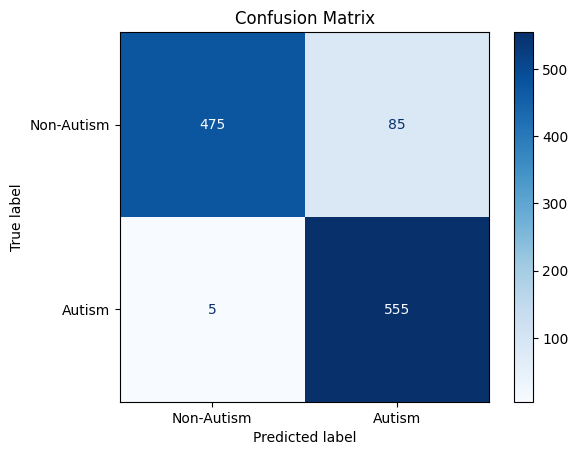

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Autism", "Autism"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


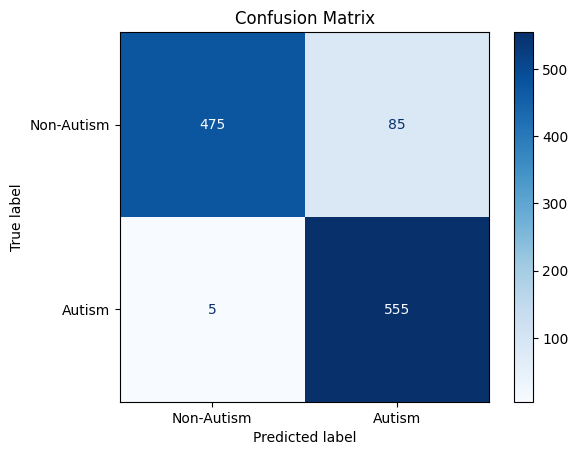

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Autism", "Autism"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [33]:
y_test_labels

array([0, 1, 0, ..., 0, 1, 0])

In [34]:
X_test

array([[-6.00946141, -2.93790874, -1.59080854, -2.88761297,  3.6584885 ,
         1.32545037],
       [-5.17536095, -2.95081928, -4.79850621, -3.38065644,  3.68362234,
         1.28527264],
       [-4.38379869, -3.13751356, -2.57505501, -1.25811178,  3.44544198,
         1.29596619],
       ...,
       [-3.22733522, -2.34017969, -2.75954596, -2.46336133,  2.63929561,
         1.36581091],
       [-4.28634603, -3.16154711, -3.58064663, -3.44335811,  2.8951099 ,
         1.39223558],
       [-4.13866901, -3.33236211, -1.17645992, -3.18101582,  2.81050329,
         1.27110892]])

In [35]:
import numpy as np

# Assuming you already have:
# features.shape => (2526, feature_dim)
# labels.shape   => (2526, 2)

# Step 1: Identify autism and non-autism indices
autism_indices = np.where((y_test == [0, 1]).all(axis=1))[0]
non_autism_indices = np.where((y_test == [1, 0]).all(axis=1))[0]

# Step 2: Select first 50 of each
selected_autism_indices = autism_indices[:50]
selected_non_autism_indices = non_autism_indices[:50]

# Step 3: Combine with autism first
selected_indices = np.concatenate([selected_autism_indices, selected_non_autism_indices])

# Step 4: Create the final test set
test_features = X_test[selected_indices]
test_labels = y_test[selected_indices]

# Optional: Verify
print("Test Features Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)
print("First 5 Labels:\n", test_labels[:5])  # Should show [0, 1]
print("Last 5 Labels:\n", test_labels[-5:])  # Should show [1, 0]


Test Features Shape: (100, 6)
Test Labels Shape: (100, 2)
First 5 Labels:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Last 5 Labels:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [36]:
y_pred_probs1 = model.predict(test_features)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [37]:
y_pred_probs2=np.load('my_array.npy')

In [38]:
import numpy as np

# Example arrays (replace with your actual data)
# eeg_probs[i] = [p_non_autism, p_autism]
# img_probs[i] = [p_non_autism, p_autism]
# Shape: (100, 2)
# Assuming both are numpy arrays

# Initialize final label array
final_labels = []

for i in range(len(y_pred_probs1)):
    # Extract probabilities
    probs = {
        "non_autism_eeg": y_pred_probs1[i][0],
        "autism_eeg": y_pred_probs1[i][1],
        "non_autism_img": y_pred_probs2[i][0],
        "autism_img": y_pred_probs2[i][1]
    }
    
    # Find the maximum probability and its class
    max_key = max(probs, key=probs.get)
    
    # Assign label based on the max key
    if "autism" in max_key:
        final_labels.append([0, 1])
    else:
        final_labels.append([1, 0])

# Convert to NumPy array
final_labels = np.array(final_labels)

# Preview
print("Final Labels Shape:", final_labels.shape)
print("First 10 Labels:\n", final_labels[:10])


Final Labels Shape: (100, 2)
First 10 Labels:
 [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(final_labels, test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 50.00%


In [ ]:
import numpy as np

# Assuming these are your inputs (shape: [100, 2])
# eeg_probs[i] = [non_autism_prob, autism_prob]
# img_probs[i] = [non_autism_prob, autism_prob]

final_labels = []

for i in range(len(y_pred_probs1)):
    # EEG decision and max prob
    eeg_max_prob = max(y_pred_probs1[i])
    eeg_pred_class = np.argmax(y_pred_probs1[i])  # 0 = non-autism, 1 = autism
                        
    # Image decision and max prob
    img_max_prob = max(y_pred_probs2[i])
    img_pred_class = np.argmax(y_pred_probs2[i])  # 0 = non-autism, 1 = autism

    # Compare max values from both modalities
    if eeg_max_prob > img_max_prob:
        final_label = [1, 0] if eeg_pred_class == 0 else [0, 1]
    else:
        final_label = [1, 0] if img_pred_class == 0 else [0, 1]

    final_labels.append(final_label)

# Convert to array
final_labels = np.array(final_labels)

# Preview
print("Final Labels Shape:", final_labels.shape)
print("First 10 Final Labels:\n", final_labels[:10])


Final Labels Shape: (100, 2)
First 10 Final Labels:
 [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


In [43]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(final_labels, test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 99.00%
